In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os
from os import listdir
from os.path import isfile, join
import importlib
from IPython.display import clear_output
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy as sc
import scipy.io as sio
import pickle
import sys
sys.path.append('..')
from MRF.Training_parameters import *
from MRF.BaseModel import *
from MRF.Projection_complex import *
from MRF.models import *
import MRF
from MRF.Offline import Network, Data_class, Performances

import matplotlib.image as mpimg

clear_output()

import torch
torch.cuda.current_device()

plt.rcParams["axes.grid"] = False

In [3]:
root_data ='/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MRF/Offline/loading_data/'

#sweep 0 basis
basis_root_seb='/gpfs/data/asslaenderlab/20200917_InVivo_MT_1mm_MWI_1p7mm/20201021_nonSweeping_Recos_n_Fits_Symmetric_Basis/'
basis0='basis_v3.2_sweep_0_std_B0_pio2_symmetric_B1_0.9pm0.2.mat'
basis_path = basis_root_seb+basis0
u=sio.loadmat(basis_path)['u']

grid = 64 
font = 10
font_large=12

R=13
noise_level=1/200
PD_mag = 100*noise_level 

In [4]:
#grid 64
# test_folder64 ='v3_test_grid64'
# test_folder64 = 'v3_uniform_b1cutoff_B0B1vary_test_allvary_random_smallT1T2'
test_folder64 = 'v3_uniform_b1cutoff_B0B1vary_test_smallT1T2'
root64 = root_data+test_folder64+'/'
save_root64=root64+'MT_paper_comparison/'

#m0s T1
finger_name = 'fingerprints_m0sT1.mat'
crb_name = 'CRBs_m0sT1.mat'
param_name = 'params_m0sT1.mat'

fingerprints_ori64_m0sT1 = sio.loadmat(root64+finger_name)['fingerprints']
params64_m0sT1 = sio.loadmat(root64+param_name)['params']
CRBs_ori64_m0sT1 = sio.loadmat(root64+crb_name)['CRBs']

#T1 T2f
finger_name = 'fingerprints_T1T2f.mat'
crb_name = 'CRBs_T1T2f.mat'
param_name = 'params_T1T2f.mat'

fingerprints_ori64_T1T2f = sio.loadmat(root64+finger_name)['fingerprints']
params64_T1T2f = sio.loadmat(root64+param_name)['params']
CRBs_ori64_T1T2f = sio.loadmat(root64+crb_name)['CRBs']

In [5]:
########### all result analysis functions

#m0s T1 testgrid        
def m0s_T1_test_grid(fingerprints,params,CRBs_original,save_path,model_name,model,noise_level=0.01,epo=200,PD_mag=0.5,grid=64):
#     noise_level=0.005
    #input compressed fingerprints
    save_root= save_path+'/'+model_name
    if not os.path.exists(save_root):
            os.makedirs(save_root)
    parametersm0s = []
    parameterst1 = []
    parameterst2 = []

    with open('../settings_files_offline/settings_'+ model_name+'.pkl', 'rb') as f:
        settings = pickle.load(f)
        net = torch.load(join('../save_networks_offline','network_'+model_name+str(epo)),map_location='cpu')
        training_parameters = Training_parameters(settings['batch_size'], 1, settings['nb_epochs'], settings['params'], settings['normalization'])
        projection = Projection(settings['start_by_projection'], settings['dimension_projection'], settings['initialization'], settings['normalization'], settings['namepca'])
        data_class = Data_class(training_parameters, settings['noise_type'], settings['noise_level'], 
                                       settings['minPD'], settings['maxPD'], settings['nb_files'], settings['path_files'])
        validation_settings = {'validation': settings['validation'],'small_validation_size': settings['small_validation_size'], 'validation_size': settings['validation_size']}
        netw = model.model(projection=projection,nb_params=len(settings['params']))
        device = torch.device('cuda')
        netw.load_state_dict(net['NN'])
        netw.to(device)

        netw.eval()
#         #CRBs = CRBs_original*settings['noise_level'] ** 2
#        #I used PD_mag=0.5 here 
#         CRBs = CRBs_original/np.tile(PD_mag*PD_mag, (1, 3))    
#         CRBs = CRBs*noise_level ** 2

        with torch.no_grad():
            for k in range(200):
                vec = fingerprints 

                # PD scale complex
                PD =  (PD_mag) * np.exp(1j * 2 * np.pi * np.random.uniform(0,1,fingerprints.shape[0]))
                PD_real = PD.real
                PD_imag = PD.imag

                PD = np.stack([PD_real,PD_imag],1)
                PD_real = np.tile(PD_real.reshape((-1, 1)), (1, vec.shape[1]))
                PD_imag = np.tile(PD_imag.reshape((-1, 1)), (1, vec.shape[1]))

                if len(vec.shape)==3:
                    vec_real = vec[:,:,0] * PD_real - vec[:,:,1]*PD_imag
                    vec_imag = vec[:, :, 1] * PD_real + vec[:, :, 0] * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                else:
                    vec_real = vec * PD_real
                    vec_imag = vec * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                fingers = vec

                PD = PD.reshape(-1, 2) # (b,2)
                PD_norm = PD[:,0]**2 + PD[:,1]**2
                PD_norm = PD_norm.reshape(-1,1)

            # add noise  
                for i in range(fingers.shape[0]):
                    noi = np.random.normal(0,noise_level,(R,2))
                    fingers[i,:,:] += noi
                fingerprints_tmpt = torch.tensor(fingers, dtype=torch.float).to(device)

                prms = netw(fingerprints_tmpt)
                prms = np.array(prms.cpu())

                # record the three parameter 
                pars = prms
                for ii, para in enumerate(settings['params']):
                    if settings['loss'][para] == 'MSE-Log':
                        pars[:, ii] = 10 ** pars[:, ii]
                parametersm0s.append(np.array(pars[:, 0]))
                parameterst1.append(np.array(pars[:, 1]))
    
    
#    #I used PD_mag=0.5 here
    CRBs = CRBs_original/np.tile(PD_norm, (1, 3)) 
    CRBs = CRBs*noise_level ** 2

    m0s = np.mean(parametersm0s, axis=0)
    bias_m0s = m0s- params[:,0]
    relabias_m0s = bias_m0s/params[:,0]
    varm0s = np.std(parametersm0s, axis=0) ** 2

    T1 = np.mean(parameterst1, axis=0)
    bias_T1 = T1-params[:,1] 
    relabias_T1 = bias_T1/params[:,1]
    varT1 = np.std(parameterst1, axis=0) ** 2

    temp = [i*grid for i in range(grid)]
    tickt1 = [round(params[i,0],4) for i in temp]

    temp2 = [i for i in range(grid)]
    tickt2 = [round(params[i,1],4) for i in temp2]

    # this is for the loss divide by the number of repeating test
    savename=os.path.join(save_root, 'm0sT1.mat')
    sio.savemat(savename, {'m0s': tickt1,
                           'crbm0s': CRBs[:,0].reshape(grid,grid),
                           'varm0s': varm0s.reshape(grid,grid),
                           'biasm0s':bias_m0s.reshape(grid,grid),
                           'relabiasm0s':relabias_m0s.reshape(grid,grid),

                           'T1': tickt2,
                           'crbT1': CRBs[:,1].reshape(grid,grid),                                           
                           'varT1': varT1.reshape(grid,grid), 
                           'biasT1':bias_T1.reshape(grid,grid),
                           'relabiasT1':relabias_T1.reshape(grid,grid),
                          })
    print(savename)
    

In [6]:
#T1 T2f testgrid
def T1_T2f_test_grid(fingerprints,params,CRBs_original,save_path,model_name,model,noise_level=0.01,epo=250,PD_mag=0.5,grid=64):
#     noise_level=0.005
    save_root= save_path+model_name
    if not os.path.exists(save_root):
        os.makedirs(save_root)

    params = np.array(params).reshape(-1,8)
    bias_res = np.zeros((params.shape[0],3))
    variance_res = np.zeros((params.shape[0],3))

    parametersm0s = []
    parameterst1 = []
    parameterst2 = []


    with open('../settings_files_offline/settings_'+ model_name+'.pkl', 'rb') as f:
        settings = pickle.load(f)
        net = torch.load(join('../save_networks_offline','network_'+model_name+str(epo)),map_location='cpu')
        training_parameters = Training_parameters(settings['batch_size'], 1, settings['nb_epochs'], settings['params'], settings['normalization'])
        projection = Projection(settings['start_by_projection'], settings['dimension_projection'], settings['initialization'], settings['normalization'], settings['namepca'])
        data_class = Data_class(training_parameters, settings['noise_type'], settings['noise_level'], 
                                       settings['minPD'], settings['maxPD'], settings['nb_files'], settings['path_files'])
        validation_settings = {'validation': settings['validation'],'small_validation_size': settings['small_validation_size'], 'validation_size': settings['validation_size']}
        netw = model.model(projection=projection,nb_params=len(settings['params']))
        device = torch.device('cuda')
        netw.load_state_dict(net['NN'])
        netw.to(device)

        netw.eval()
#         #CRBs = CRBs_ori*settings['noise_level'] ** 2
#         CRBs = CRBs_ori*noise_level ** 2
#         CRBs = CRBs/np.tile(PD_mag*PD_mag, (1, 3)) 
        with torch.no_grad():
            for k in range(150):
                vec = fingerprints

                # PD scale complex
                PD =  (PD_mag) * np.exp(1j * 2 * np.pi * np.random.uniform(0,1,vec.shape[0]))
                PD_real = PD.real
                PD_imag = PD.imag

                PD = np.stack([PD_real,PD_imag],1)
                PD_real = np.tile(PD_real.reshape((-1, 1)), (1, vec.shape[1]))
                PD_imag = np.tile(PD_imag.reshape((-1, 1)), (1, vec.shape[1]))
                
                if len(vec.shape)==3:
                    vec_real = vec[:,:,0] * PD_real - vec[:,:,1]*PD_imag
                    vec_imag = vec[:, :, 1] * PD_real + vec[:, :, 0] * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                else:
                    vec_real = vec * PD_real
                    vec_imag = vec * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                fingers = vec

                PD = PD.reshape(-1, 2) # (b,2)
                PD_norm = PD[:,0]**2 + PD[:,1]**2
                PD_norm = PD_norm.reshape(-1,1)

            # add noise  
                for i in range(fingers.shape[0]):
                    noi = np.random.normal(0,noise_level,(R,2))
                    fingers[i,:,:] += noi
                fingerprints_tmpt = torch.tensor(fingers, dtype=torch.float).to(device)


                prms = netw(fingerprints_tmpt)
                prms = np.array(prms.cpu())


                # record the three parameter 
                pars = prms
                for ii, para in enumerate(settings['params']):
                    if settings['loss'][para] == 'MSE-Log':
                        pars[:, ii] = 10 ** pars[:, ii]
                parametersm0s.append(np.array(pars[:, 0]))
                parameterst1.append(np.array(pars[:, 1]))
                parameterst2.append(np.array(pars[:, 2]))

    #    #I used PD_mag=0.5 here
    CRBs = CRBs_original/np.tile(PD_norm, (1, 3)) 
    CRBs = CRBs*noise_level ** 2

    m0s = np.mean(parametersm0s, axis=0)
    bias_m0s = m0s- params[:,0]
    varm0s = np.std(parametersm0s, axis=0) ** 2

    T1 = np.mean(parameterst1, axis=0)
    bias_T1 = T1-params[:,1] 
    relabias_T1 = bias_T1/params[:,1]
    varT1 = np.std(parameterst1, axis=0) ** 2

    T2 = np.mean(parameterst2, axis=0)
    bias_T2 = T2-params[:,2]
    relabias_T2 = bias_T2/params[:,2] # T2/params[:,2] -1
    varT2 = np.std(parameterst2, axis=0) ** 2

    temp = [i*grid for i in range(grid)]
    tickt1 = [round(params[i,1],4) for i in temp]

    temp2 = [i for i in range(grid)]
    tickt2 = [round(params[i,2],4) for i in temp2]
    # this is for the loss divide by the number of repeating test
    print('done validation test:'+model_name)

    savename=os.path.join(save_root, 'T1T2f.mat')
    print(savename)
    sio.savemat(savename, {'T1': tickt1,
                          'crbT1': CRBs[:,1].reshape(grid,grid),                                           
                          'varT1': varT1.reshape(grid,grid), 
                          'biasT1':bias_T1.reshape(grid,grid),
                          'relabiasT1':relabias_T1.reshape(grid,grid),

                           'T2f': tickt2,
                           'crbT2f': CRBs[:,2].reshape(grid,grid),
                           'varT2f': varT2.reshape(grid,grid),
                           'biasT2f':bias_T2.reshape(grid,grid),
                           'relabiasT2f':relabias_T2.reshape(grid,grid),
                          })

In [7]:
def plot_testgrid_m0s(data,title,row = 1,col = 3,bais_cmap='bwr',crb_cmap='YlOrBr'):
    ##==================T1 m0s================
    font_small=10
    font=12
    n=1
    accuracy=0.02
    ax = plt.figure(figsize=(13,2))
    ax=plt.subplot(row, col, n)
    im=data['biasm0s']
    T1=data['T1']
    m0s=data['m0s']
    c = ax.imshow(im, origin='lower', extent=[np.min(T1), np.max(T1), np.min(m0s), np.max(m0s)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font_small)
    ax.set_ylabel(title+'\n'+'$m_0^s$', fontsize=font_small)
    plt.title('est(m0s)-m0s', fontsize=font)
    plt.colorbar(c)
    n=n+1
    #variance
    accuracy=0.02
    ax=plt.subplot(row, col, n)
    im=data['varm0s']
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(m0s), np.max(m0s)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    plt.title('varm0s', fontsize=10)
    plt.colorbar(c)
    n=n+1
    #crb
    ax=plt.subplot(row, col, n)
    im=data['crbm0s']
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(m0s), np.max(m0s)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    plt.title('crbm0s', fontsize=10)
    plt.colorbar(c)
    n=n+1
    
def plot_testgrid_T1(data,title,row = 1,col = 3,bais_cmap='bwr',crb_cmap='YlOrBr'):
    font_small=10
    font=12
    ax = plt.figure(figsize=(13,2))
    n=1
    ax=plt.subplot(row, col, n)
    accuracy=0.3
    im=data['biasT1']
    T1=data['T1']
    T2f=data['T2f']
    c = ax.imshow(im, origin='lower', extent=[np.min(T2f), np.max(T2f), np.min(T1), np.max(T1)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_2^f$ (s)', fontsize=font_small)
    ax.set_ylabel(title+'\n'+'$T_1$', fontsize=font_small)
    plt.title('est(T1)-T1', fontsize=font)
    plt.colorbar(c)
    n=n+1
    #variance T1
    accuracy=0.3
    ax=plt.subplot(row, col, n)
    im=data['varT1']
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T2f), np.max(T2f), np.min(T1), np.max(T1)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    plt.title('varT1', fontsize=10)
    plt.colorbar(c)
    n=n+1
    #crb T1
    ax=plt.subplot(row, col, n)
    im=data['crbT1']
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T2f), np.max(T2f), np.min(T1), np.max(T1)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    plt.title('crbT1', fontsize=10)
    plt.colorbar(c)
    n=n+1

def plot_testgrid_T2(data,title,row = 1,col = 3,bais_cmap='bwr',crb_cmap='YlOrBr'):
    font_small=10
    font=12
    ax = plt.figure(figsize=(13,2))
    #ax.suptitle('Main title')
    n=1
    im=data['biasT2f']
    T1=data['T1']
    T2f=data['T2f']
    ax=plt.subplot(row, col, n)
    accuracy=0.02
    c = ax.imshow(im, origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel(title+'\n'+'$T_2^f$', fontsize=font)
    plt.title('est(T_2^f)-T_2^f', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

    #variance
    accuracy=0.02
    im=data['varT2f']
    ax=plt.subplot(row, col, n)
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel('$T_2^f$', fontsize=font)
    plt.title('varT_2^f', fontsize=font_large)
    plt.colorbar(c)
    n=n+1
    #crb
    im=data['crbT2f']
    ax=plt.subplot(row, col, n)
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel('$T_2^f$', fontsize=font)
    plt.title('crbT_2^f', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

## final paper plot

In [8]:
## define model names for paper
R=13
#model name
model = importlib.import_module('MRF.models.full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection')


In [10]:
model_name_list=[
    'd0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file', #best 350
    'd0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1000_1024_largerval_train',
    'd0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file']
model_title_list=['CRB','MSE']

In [17]:
epo=700
save_root='/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64small_SNR50_epo'+str(epo)+'/'
import os
if not os.path.exists(save_root):
    os.makedirs(save_root)
#(1) compute testgrid values
# m0s T1 
fingerprints = np.matmul(fingerprints_ori64_m0sT1,u[:,0:R])
fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)
for i in range(0,3): 
    model_name = model_name_list[i]
    m0s_T1_test_grid(fingerprints,params64_m0sT1,CRBs_ori64_m0sT1,save_root,model_name,model,noise_level=0.01,epo=epo)

# T1 T2f grid=64
fingerprints = np.matmul(fingerprints_ori64_T1T2f,u[:,0:R])
fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)
for i in range(0,3): 
    model_name = model_name_list[i]
    T1_T2f_test_grid(fingerprints,params64_T1T2f,CRBs_ori64_T1T2f,save_root,model_name,model,noise_level=0.01,epo=epo)

/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64small_SNR50_epo700//d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file/m0sT1.mat
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64small_SNR50_epo700//d0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1000_1024_largerval_train/m0sT1.mat
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64small_SNR50_epo700//d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file/m0sT1.mat
done validation test:d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64small_SNR50_epo700/d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file/T1T2f.mat
done validation test:d0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1000_1024

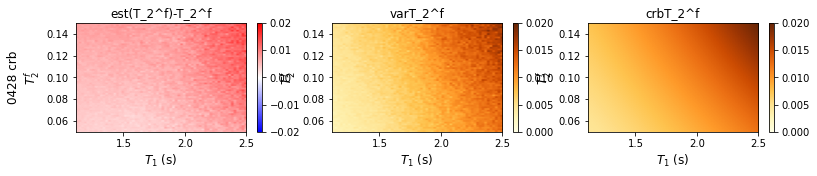

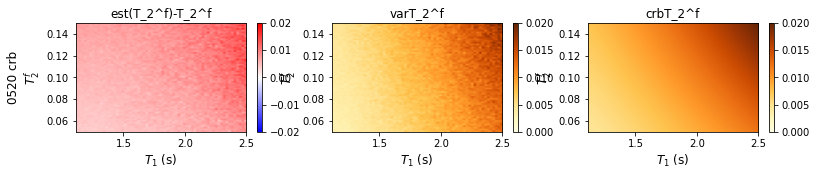

In [294]:
save_root0='/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64_SNR50_epo350/'
save_root1='/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64_SNR50_epo300/'
save_root2='/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64_SNR50_epo400/'

# # # # (2)plot testgrid
# for i in [0]:#range(0,3):
#     model_name=model_name_list[i]
#     print(save_root+model_name+'/'+'m0sT1.mat')
    
#     data = sio.loadmat(save_root0+model_name_list[0]+'/'+'m0sT1.mat')
#     plot_testgrid_m0s(data,'0428 crb')
#     data = sio.loadmat(save_root1+model_name_list[1]+'/'+'m0sT1.mat')
#     plot_testgrid_m0s(data,'0520 crb')
#     data = sio.loadmat(save_root2+model_name_list[2]+'/'+'m0sT1.mat')
#     plot_testgrid_m0s(data,'0428 mse')

# for i in [0]:#range(0,3):
#     model_name=model_name_list[i]
    
#     data = sio.loadmat(save_root0+model_name_list[0]+'/'+'T1T2f.mat')
#     plot_testgrid_T1(data,model_title_list[i])
#     data = sio.loadmat(save_root1+model_name_list[1]+'/'+'T1T2f.mat')
#     plot_testgrid_T1(data,model_title_list[i])
#     data = sio.loadmat(save_root2+model_name_list[2]+'/'+'T1T2f.mat')
#     plot_testgrid_T1(data,model_title_list[i])
    
for i in [0]:#range(0,3):
    model_name=model_name_list[i]   
    
    data = sio.loadmat(save_root0+model_name_list[0]+'/'+'T1T2f.mat')
    plot_testgrid_T2(data,'0428 crb')
    data = sio.loadmat(save_root1+model_name_list[1] +'/'+'T1T2f.mat')
    plot_testgrid_T2(data,'0520 crb')
#     data = sio.loadmat(save_root2+model_name_list[2] +'/'+'T1T2f.mat')
#     plot_testgrid_T2(data,'0428 mse')

/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64_SNR50_epo120/d0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1000_1024_largerval_train/m0sT1.mat


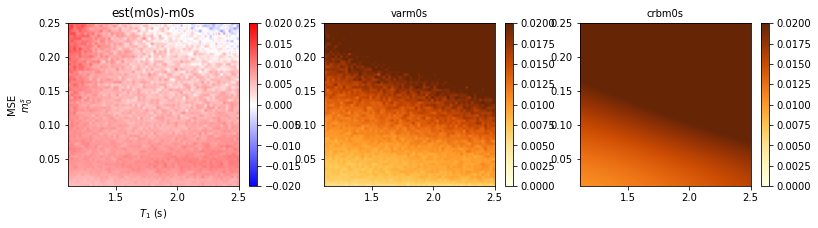

In [203]:
# save_root='/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64_SNR50_epo50/'
#(2)plot testgrid
for i in [1]:#range(0,3):
    model_name=model_name_list[i]
    print(save_root+model_name+'/'+'m0sT1.mat')
    data = sio.loadmat(save_root+model_name+'/'+'m0sT1.mat')
    plot_testgrid_m0s(data,model_title_list[i])

# for i in [1]:#range(0,3):
#     model_name=model_name_list[i]
#     data = sio.loadmat(save_root+model_name+'/'+'T1T2f.mat')
#     plot_testgrid_T1(data,model_title_list[i])
    
# for i in [1]:#range(0,3):
#     model_name=model_name_list[i]   
#     data = sio.loadmat(save_root+model_name+'/'+'T1T2f.mat')
#     plot_testgrid_T2(data,model_title_list[i])

In [281]:
epoch_list_mse=[]
for i in range(0,2000):
    name=join('../save_networks_offline','network_'+model_name_list[1]+str(i))
    if os.path.exists(name):
        epoch_list_mse = np.append(epoch_list_mse,i)
print(len(epoch_list_mse))
print(epoch_list_mse)

66
[  0.   2.   4.   6.   8.  10.  12.  14.  15.  16.  18.  20.  22.  24.
  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  45.  46.  48.  50.
  52.  56.  60.  64.  68.  72.  75.  76.  80.  84.  88.  90.  92.  96.
 100. 104. 105. 112. 120. 128. 135. 136. 140. 144. 150. 160. 165. 180.
 195. 200. 220. 240. 250. 300. 400. 500. 600. 700.]


In [252]:
good=[350]#2,10,15,16,22,26,75,18,32,45,2,5,95,100,150,52,45

In [253]:
len(good)

5

In [12]:
for i in [350,400]:
    epo=int(i)
    for j in [0,2]:
        model_name = model_name_list[j]
        name=join('../save_networks_offline','network_'+model_name+str(epo))

        save_root='/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64_SNR25_epo'+str(epo)+'/'
        if not os.path.exists(save_root):
            os.makedirs(save_root)

        if os.path.exists(name):        
            fingerprints = np.matmul(fingerprints_ori64_m0sT1,u[:,0:R])
            fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)
            m0s_T1_test_grid(fingerprints,params64_m0sT1,CRBs_ori64_m0sT1,save_root,model_name,model,noise_level=0.02,epo=epo)

            fingerprints = np.matmul(fingerprints_ori64_T1T2f,u[:,0:R])
            fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)
            T1_T2f_test_grid(fingerprints,params64_T1T2f,CRBs_ori64_T1T2f,save_root,model_name,model,noise_level=0.02,epo=epo)
        
#         data1 = sio.loadmat(save_root+model_name+'/'+'m0sT1.mat')
#         data2 = sio.loadmat(save_root+model_name+'/'+'T1T2f.mat')
#         plot_testgrid_all(data1,data2,str(epo))

/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64_SNR25_epo350//d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file/m0sT1.mat
done validation test:d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64_SNR25_epo350/d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file/T1T2f.mat
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64_SNR25_epo350//d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file/m0sT1.mat
done validation test:d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MT_paper/heatmap_grid64_SNR25_epo350/d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file/T1T2f.mat
/gpfs/data/asslaenderlab/share

In [219]:
def plot_testgrid_all(data1,data2,title,row = 1,col = 3,bais_cmap='bwr',crb_cmap='YlOrBr'):
    ##==================T1 m0s================
    data = data1
    font_small=10
    font=12
    n=1
    accuracy=0.02
    ax = plt.figure(figsize=(9,1))
    ax=plt.subplot(row, col, n)
    im=data['biasm0s']
    T1=data['T1']
    m0s=data['m0s']
    c = ax.imshow(im, origin='lower', extent=[np.min(T1), np.max(T1), np.min(m0s), np.max(m0s)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_ylabel(title+'\n'+'$m_0^s$', fontsize=font_small)
    plt.colorbar(c)
    n=n+1

    data = data2
    ax=plt.subplot(row, col, n)
    accuracy=0.3
    im=data['biasT1']
    T1=data['T1']
    T2f=data['T2f']
    c = ax.imshow(im, origin='lower', extent=[np.min(T2f), np.max(T2f), np.min(T1), np.max(T1)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_ylabel(title+'\n'+'$T_1$', fontsize=font_small)
    plt.colorbar(c)
    n=n+1
    
    data = data2
    im=data['biasT2f']
    T1=data['T1']
    T2f=data['T2f']
    ax=plt.subplot(row, col, n)
    accuracy=0.02
    c = ax.imshow(im, origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")

    ax.set_ylabel(title+'\n'+'$T_2^f$', fontsize=font)
    plt.title('est(T_2^f)-T_2^f', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

## find the best for T2f

In [11]:
model = importlib.import_module('MRF.models.full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection')
list1=[
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001_noise_0.0005',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001_noise_0.001',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001_noise0.005_1000file',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001_noise0.005_500file',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001_noise0.005_800file',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001_noise0.005_PD1',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001_noise_0.01',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001_noise_0.1',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001_noise_free',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.005',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R20_p3_lr_0.001',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R20_p3_lr_0.005',
'network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R20_p3_lr_0.01',
'network_d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_PD1_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.00001_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.0001_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.003_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.005_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.008_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_500file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_600file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_800file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.02_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.04_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.06_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.08_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.1_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.15_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.2_1100file',
'network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.5_1100file',
'network_d0511_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file',

'network_d0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_550_1024',
'network_d0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_550_1024_256',
'network_d0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_550_1024_duringepoch',
'network_d0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_550_1024_duringepoch_largerval',
'network_d0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_590_1024_largerval_train',
'network_d0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_590_1024_largerval_train_after',
'network_d0526_MSE_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1000_1024_larger_val_train_model',
'network_d0526_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1000_1024_larger_val_train_model',
'network_d0526_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1000_1024_smaller_val_train_model',
]

In [12]:
list2=['network_d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file',
'network_d0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1000_1024_largerval_train']

In [19]:
list1_good1=[3,11,24,34] #0,15,11,18,26，36,35]


In [20]:
for i in list1_good1:
    print(list1[i])

network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001_noise0.005_1000file
network_d0423_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01
network_d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.02_1100file
network_d0520_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_550_1024_256


In [15]:
fingerprints = np.matmul(fingerprints_ori64_T1T2f,u[:,0:R])
fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)

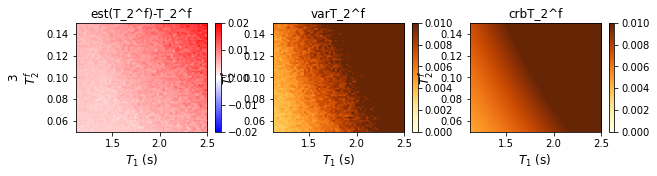

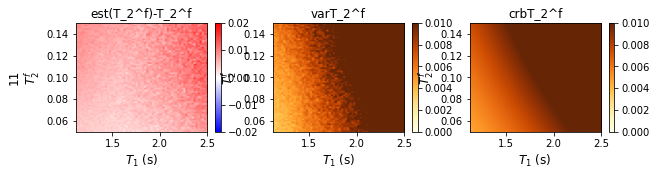

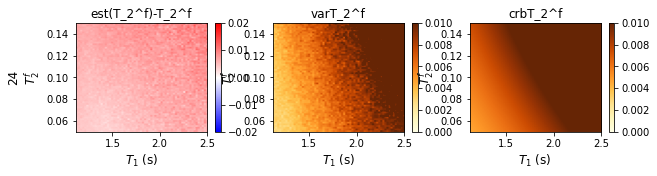

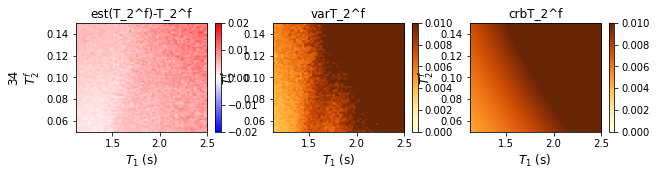

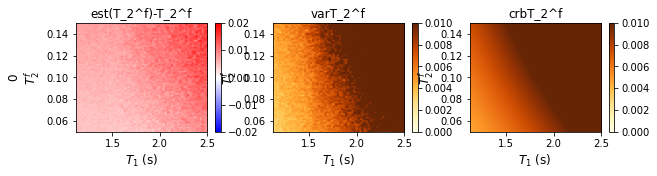

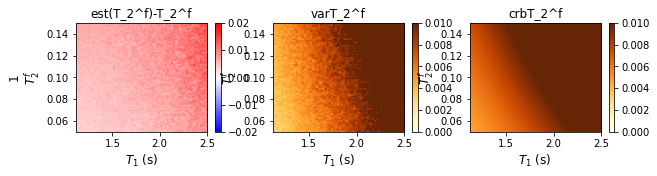

In [21]:
# T1 T2f grid=64
for i in list1_good1: 
    model_name = list1[i]
    T1_T2f_test_grid_quicktest(fingerprints,params64_T1T2f,CRBs_ori64_T1T2f,save_root64,model_name,model,num_list=i,epo=None)

for i in [0,1]: 
    model_name = list2[i]
    T1_T2f_test_grid_quicktest(fingerprints,params64_T1T2f,CRBs_ori64_T1T2f,save_root64,model_name,model,num_list=i,epo=400)

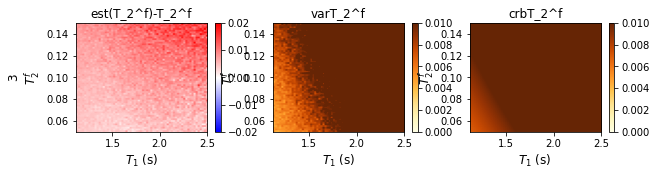

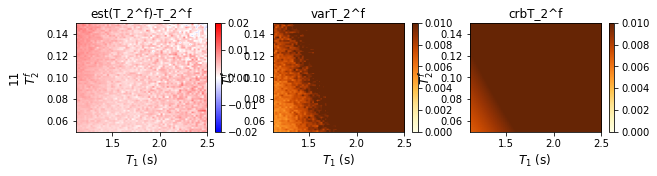

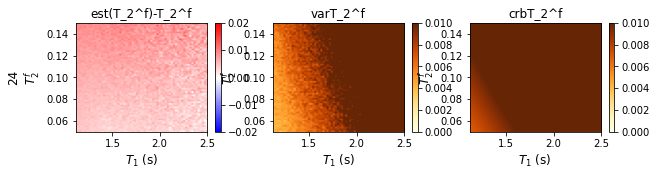

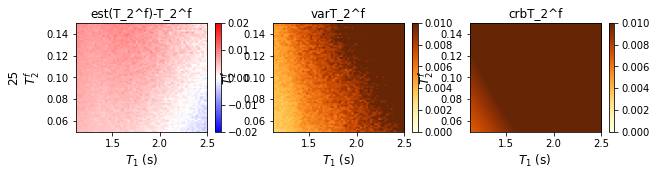

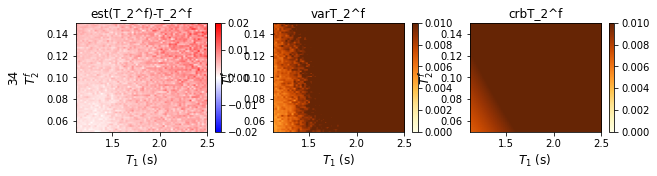

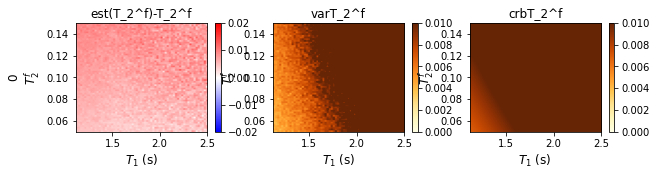

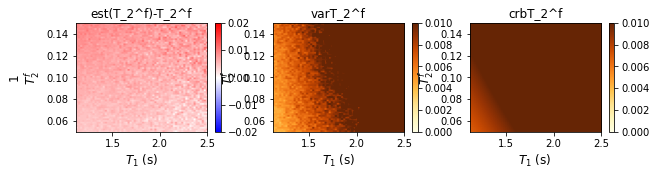

In [18]:
fingerprints = np.matmul(fingerprints_ori64_T1T2f,u[:,0:R])
fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)
for i in list1_good1: 
    model_name = list1[i]
    T1_T2f_test_grid_quicktest(fingerprints,params64_T1T2f,CRBs_ori64_T1T2f,save_root64,model_name,model,noise_level=0.015,num_list=i,epo=None)

for i in [0,1]: 
    model_name = list2[i]
    T1_T2f_test_grid_quicktest(fingerprints,params64_T1T2f,CRBs_ori64_T1T2f,save_root64,model_name,model,noise_level=0.015,num_list=i,epo=400)

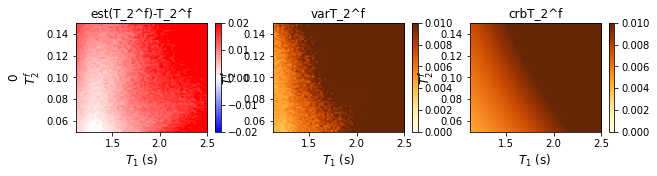

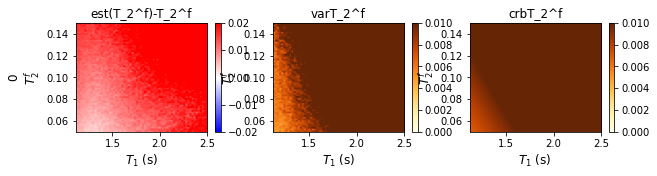

In [8]:
model = importlib.import_module('MRF.models.full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection')
name_mse='network_d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file'
T1_T2f_test_grid_quicktest(fingerprints,params64_T1T2f,CRBs_ori64_T1T2f,save_root64,name_mse,model,noise_level=0.01,num_list=0,epo=400)
T1_T2f_test_grid_quicktest(fingerprints,params64_T1T2f,CRBs_ori64_T1T2f,save_root64,name_mse,model,noise_level=0.015,num_list=0,epo=400)

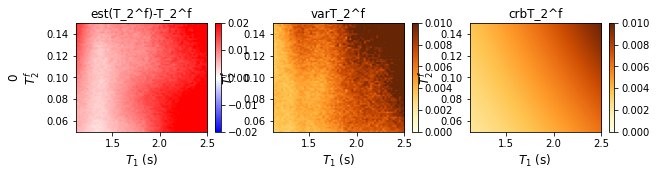

In [7]:
T1_T2f_test_grid_quicktest(fingerprints,params64_T1T2f,CRBs_ori64_T1T2f,save_root64,name_mse,model,noise_level=0.005,num_list=0,epo=100)

In [4]:
#T1 T2f testgrid
def T1_T2f_test_grid_quicktest(fingerprints,params,CRBs_ori,save_path,model_name,model,num_list,noise_level = 0.01,epo=None,grid=64):
#     print(num_list)
    PD_mag = 0.5
    save_root= save_path+model_name+'250'
    if not os.path.exists(save_root):
        os.makedirs(save_root)

    params = np.array(params).reshape(-1,8)
    bias_res = np.zeros((params.shape[0],3))
    variance_res = np.zeros((params.shape[0],3))

    parametersm0s = []
    parameterst1 = []
    parameterst2 = []


    with open('../settings_files_offline/settings_'+ model_name[8:]+'.pkl', 'rb') as f:
        settings = pickle.load(f)
        if epo is not None:
            net = torch.load(join('../save_networks_offline',model_name+str(epo)),map_location='cpu')
        else:
            net = torch.load(join('../save_networks_offline',model_name),map_location='cpu')
                             
        training_parameters = Training_parameters(settings['batch_size'], 1, settings['nb_epochs'], settings['params'], settings['normalization'])
        projection = Projection(settings['start_by_projection'], settings['dimension_projection'], settings['initialization'], settings['normalization'], settings['namepca'])
        data_class = Data_class(training_parameters, settings['noise_type'], settings['noise_level'], 
                                       settings['minPD'], settings['maxPD'], settings['nb_files'], settings['path_files'])
        validation_settings = {'validation': settings['validation'],'small_validation_size': settings['small_validation_size'], 'validation_size': settings['validation_size']}
        netw = model.model(projection=projection,nb_params=len(settings['params']))
        device = torch.device('cuda')
        netw.load_state_dict(net['NN'])
        netw.to(device)

        netw.eval()
#         #CRBs = CRBs_ori*settings['noise_level'] ** 2
#         CRBs = CRBs_ori*noise_level ** 2
#         CRBs = CRBs/np.tile(PD_mag*PD_mag, (1, 3)) 
        with torch.no_grad():
            for k in range(100):
                vec = fingerprints

                # PD scale complex
                PD =  (PD_mag) * np.exp(1j * 2 * np.pi * np.random.uniform(0,1,vec.shape[0]))
                PD_real = PD.real
                PD_imag = PD.imag

                PD = np.stack([PD_real,PD_imag],1)
                PD_real = np.tile(PD_real.reshape((-1, 1)), (1, vec.shape[1]))
                PD_imag = np.tile(PD_imag.reshape((-1, 1)), (1, vec.shape[1]))
                
                if len(vec.shape)==3:
                    vec_real = vec[:,:,0] * PD_real - vec[:,:,1]*PD_imag
                    vec_imag = vec[:, :, 1] * PD_real + vec[:, :, 0] * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                else:
                    vec_real = vec * PD_real
                    vec_imag = vec * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                fingers = vec

                PD = PD.reshape(-1, 2) # (b,2)
                PD_norm = PD[:,0]**2 + PD[:,1]**2
                PD_norm = PD_norm.reshape(-1,1)

            # add noise  
                for i in range(fingers.shape[0]):
                    noi = np.random.normal(0,noise_level,(R,2))
                    fingers[i,:,:] += noi
                fingerprints_tmpt = torch.tensor(fingers, dtype=torch.float).to(device)


                prms = netw(fingerprints_tmpt)
                prms = np.array(prms.cpu())


                # record the three parameter 
                pars = prms
                for ii, para in enumerate(settings['params']):
                    if settings['loss'][para] == 'MSE-Log':
                        pars[:, ii] = 10 ** pars[:, ii]
                parametersm0s.append(np.array(pars[:, 0]))
                parameterst1.append(np.array(pars[:, 1]))
                parameterst2.append(np.array(pars[:, 2]))

    #    #I used PD_mag=0.5 here
    CRBs = CRBs_ori/np.tile(PD_norm, (1, 3)) 
    CRBs = CRBs*noise_level ** 2
    
    m0s = np.mean(parametersm0s, axis=0)
    bias_m0s = m0s- params[:,0]
    varm0s = np.std(parametersm0s, axis=0) ** 2

    T1 = np.mean(parameterst1, axis=0)
    bias_T1 = T1-params[:,1] 
    relabias_T1 = T1/params[:,1] -1
    varT1 = np.std(parameterst1, axis=0) ** 2

    T2 = np.mean(parameterst2, axis=0)
    bias_T2 = T2-params[:,2]
    relabias_T2 = T2/params[:,2] -1
    varT2 = np.std(parameterst2, axis=0) ** 2

    temp = [i*grid for i in range(grid)]
    tickt1 = [round(params[i,1],4) for i in temp]

    temp2 = [i for i in range(grid)]
    tickt2 = [round(params[i,2],4) for i in temp2]
    # this is for the loss divide by the number of repeating test
#     print('done validation test:'+model_name)

    savename=os.path.join(save_root, 'T1T2f.mat')
#     print(savename)
#     sio.savemat(savename, {'T1': tickt1,
#                           'crbT1': CRBs[:,1].reshape(grid,grid),                                           
#                           'varT1': varT1.reshape(grid,grid), 
#                           'biasT1':bias_T1.reshape(grid,grid),
#                           'relabiasT1':relabias_T1.reshape(grid,grid),

#                            'T2f': tickt2,
#                            'crbT2f': CRBs[:,2].reshape(grid,grid),
#                            'varT2f': varT2.reshape(grid,grid),
#                            'biasT2f':bias_T2.reshape(grid,grid),
#                            'relabiasT2f':relabias_T2.reshape(grid,grid),
#                           })
    data={'T1': tickt1,
          'crbT1': CRBs[:,1].reshape(grid,grid),                                           
          'varT1': varT1.reshape(grid,grid), 
          'biasT1':bias_T1.reshape(grid,grid),
          'relabiasT1':relabias_T1.reshape(grid,grid),

           'T2f': tickt2,
           'crbT2f': CRBs[:,2].reshape(grid,grid),
           'varT2f': varT2.reshape(grid,grid),
           'biasT2f':bias_T2.reshape(grid,grid),
           'relabiasT2f':relabias_T2.reshape(grid,grid),
         }
    plot_testgrid_T2(data,str(num_list))

def plot_testgrid_T2(data,title,row = 1,col = 3,bais_cmap='bwr',crb_cmap='YlOrBr'):
    font_small=10
    font=12
    ax = plt.figure(figsize=(10,2))
    #ax.suptitle('Main title')
    n=1
    im=data['biasT2f']
    T1=data['T1']
    T2f=data['T2f']
    ax=plt.subplot(row, col, n)
    accuracy=0.02
    c = ax.imshow(im, origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel(title+'\n'+'$T_2^f$', fontsize=font)
    plt.title('est(T_2^f)-T_2^f', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

    #variance
    accuracy=0.01
    im=data['varT2f']
    ax=plt.subplot(row, col, n)
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel('$T_2^f$', fontsize=font)
    plt.title('varT_2^f', fontsize=font_large)
    plt.colorbar(c)
    n=n+1
    #crb
    im=data['crbT2f']
    ax=plt.subplot(row, col, n)
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel('$T_2^f$', fontsize=font)
    plt.title('crbT_2^f', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

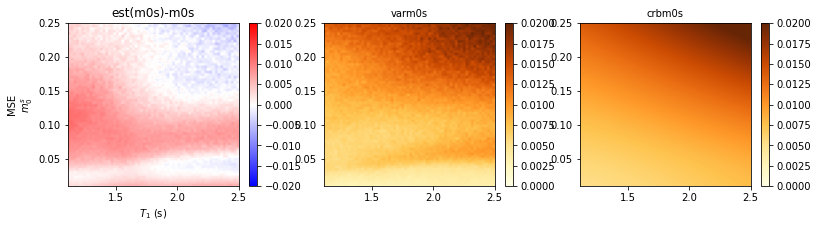

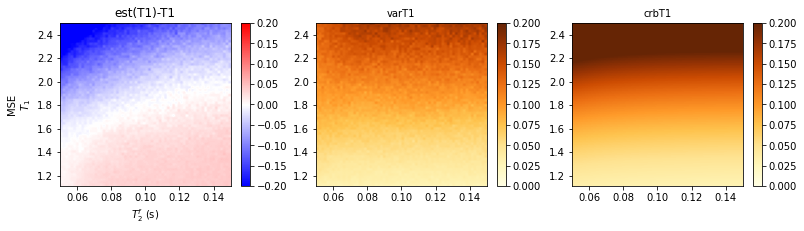

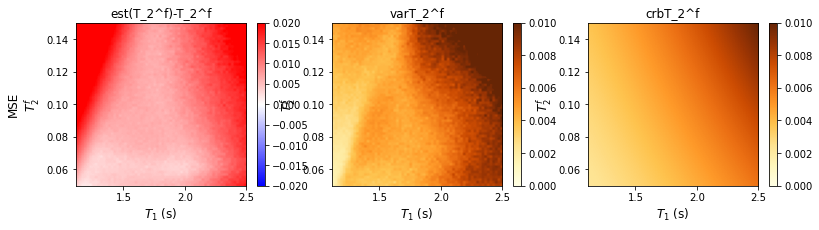

In [19]:
#(2)plot testgrid
for i in [2]:#range(0,3):
    model_name=model_name_list[i]
    data = sio.loadmat(save_root64+model_name+'/'+'m0sT1.mat')
    plot_testgrid_m0s(data,model_title_list[i])

for i in [2]:#range(0,3):
    model_name=model_name_list[i]
    data = sio.loadmat(save_root64+model_name+'/'+'T1T2f.mat')
    plot_testgrid_T1(data,model_title_list[i])
    
for i in [2]:#range(0,3):
    model_name=model_name_list[i]   
    data = sio.loadmat(save_root64+model_name+'/'+'T1T2f.mat')
    plot_testgrid_T2(data,model_title_list[i])

## ############

In [42]:
# m0s T1 grid=64
R=13
fingerprints = np.matmul(fingerprints_ori64_m0sT1,u[:,0:R])
fingerprints_m0sT1 = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)

fingerprints = np.matmul(fingerprints_ori64_T1T2f,u[:,0:R])
fingerprints_T1T2f = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)

model = importlib.import_module('MRF.models.full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection')
#model_name_base='d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file'
model_name_base='d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file'
             
for i in [0,50,100,150,200,250]:
    model_name=model_name_base+str(i)
    title = str(i)
    m0s_T1_test_grid_epochloop(fingerprints_m0sT1,params64_m0sT1,CRBs_ori64_m0sT1,save_root64,model_name_base,model_name,model,grid=64)
#     T1_T2f_test_grid_epochloop(fingerprints_T1T2f,params64_T1T2f,CRBs_ori64_T1T2f,save_root64,model_name_base,model_name,model,grid=64)

model_name_base='d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file'             
for i in [0,50,100,150,200,250]:
    model_name=model_name_base+str(i)
    title = str(i)
    m0s_T1_test_grid_epochloop(fingerprints_m0sT1,params64_m0sT1,CRBs_ori64_m0sT1,save_root64,model_name_base,model_name,model,grid=64)
#     T1_T2f_test_grid_epochloop(fingerprints_T1T2f,params64_T1T2f,CRBs_ori64_T1T2f,save_root64,model_name_base,model_name,model,grid=64)

/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MRF/Offline/loading_data/v3_test_grid64/MT_paper_comparison//d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file0/m0sT1.mat
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MRF/Offline/loading_data/v3_test_grid64/MT_paper_comparison//d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file50/m0sT1.mat
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MRF/Offline/loading_data/v3_test_grid64/MT_paper_comparison//d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file100/m0sT1.mat
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MRF/Offline/loading_data/v3_test_grid64/MT_paper_comparison//d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file150/m0sT1.mat
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MRF/Offline/loading_data/v3_test_grid64/MT_paper_comparison//d0428_v3_nonsweep_varyB0B1_co

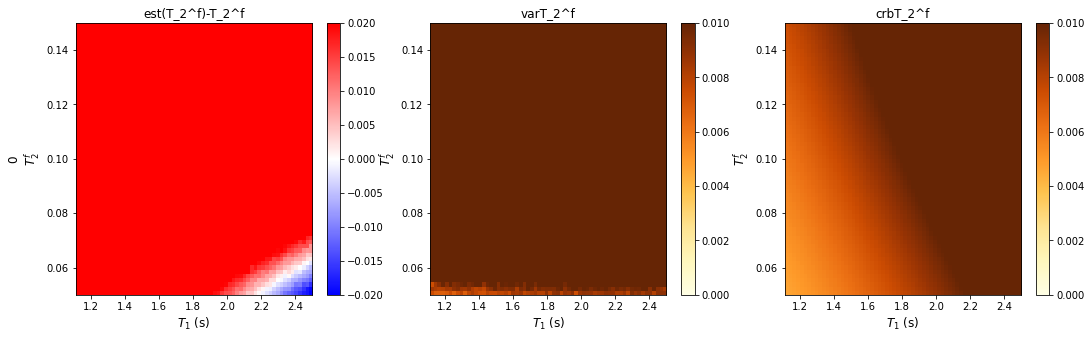

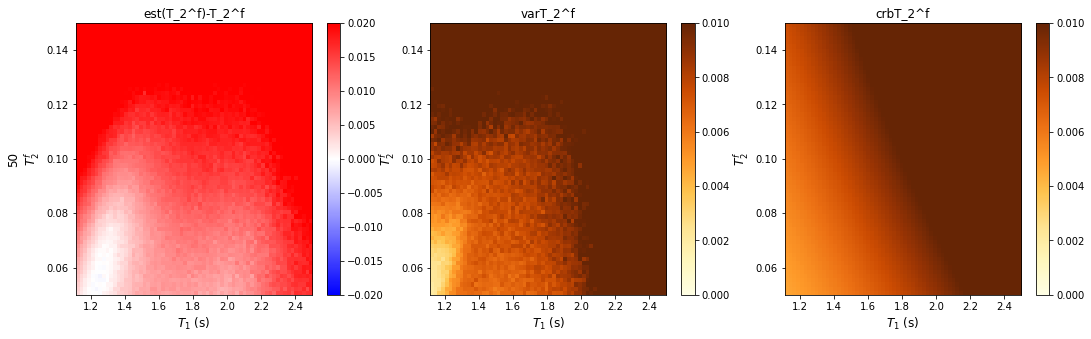

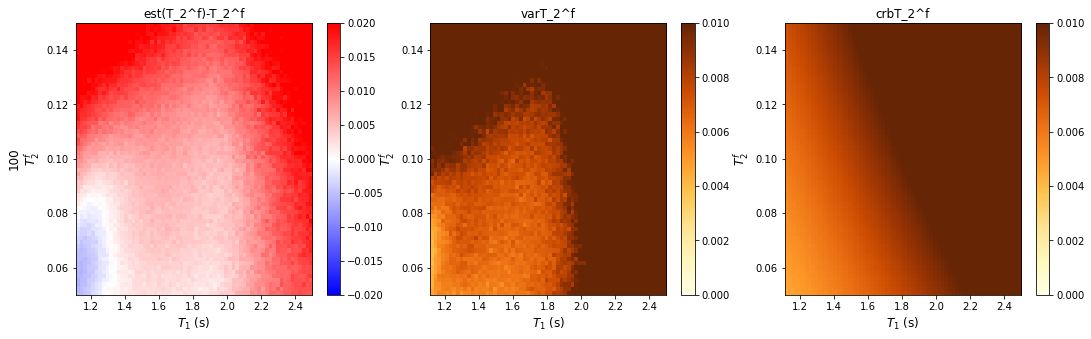

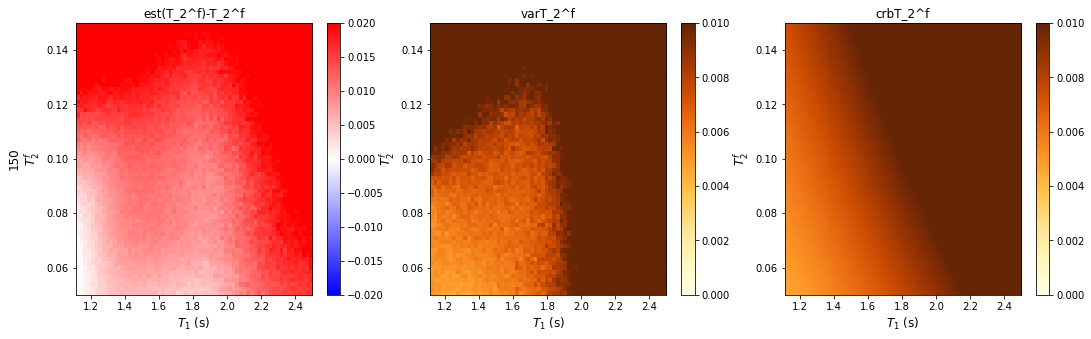

In [8]:
model = importlib.import_module('MRF.models.full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection')
model_name_base='d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file'
#model_name_base='d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file'
#',
for i in [0,50,100,150]:
    model_name=model_name_base+str(i)
    title = str(i)
    #data = sio.loadmat(save_root64+model_name+'/'+'m0sT1.mat')
    data = sio.loadmat(save_root64+model_name+'/'+'T1T2f.mat')
    plot_testgrid_T2(data,title)

In [41]:
def m0s_T1_test_grid_epochloop(fingerprints,params,CRBs_original,save_path,model_name_base,model_name,model,grid=64):
    #input compressed fingerprints
    save_root= save_path+'/'+model_name
    if not os.path.exists(save_root):
            os.makedirs(save_root)
    parametersm0s = []
    parameterst1 = []
    parameterst2 = []

    with open('../settings_files_offline/settings_'+ model_name_base+'.pkl', 'rb') as f:
        settings = pickle.load(f)
        net = torch.load(join('../save_networks_offline','network_'+model_name),map_location='cpu')
        training_parameters = Training_parameters(settings['batch_size'], 1, settings['nb_epochs'], settings['params'], settings['normalization'])
        projection = Projection(settings['start_by_projection'], settings['dimension_projection'], settings['initialization'], settings['normalization'], settings['namepca'])
        data_class = Data_class(training_parameters, settings['noise_type'], settings['noise_level'], 
                                       settings['minPD'], settings['maxPD'], settings['nb_files'], settings['path_files'])
        validation_settings = {'validation': settings['validation'],'small_validation_size': settings['small_validation_size'], 'validation_size': settings['validation_size']}
        netw = model.model(projection=projection,nb_params=len(settings['params']))
        device = torch.device('cuda')
        netw.load_state_dict(net['NN'])
        netw.to(device)

        netw.eval()
        with torch.no_grad():
            for k in range(300):
                vec = fingerprints 

                # PD scale complex
                PD =  (PD_mag) * np.exp(1j * 2 * np.pi * np.random.uniform(0,1,fingerprints.shape[0]))
                PD_real = PD.real
                PD_imag = PD.imag

                PD = np.stack([PD_real,PD_imag],1)
                PD_real = np.tile(PD_real.reshape((-1, 1)), (1, vec.shape[1]))
                PD_imag = np.tile(PD_imag.reshape((-1, 1)), (1, vec.shape[1]))

                if len(vec.shape)==3:
                    vec_real = vec[:,:,0] * PD_real - vec[:,:,1]*PD_imag
                    vec_imag = vec[:, :, 1] * PD_real + vec[:, :, 0] * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                else:
                    vec_real = vec * PD_real
                    vec_imag = vec * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                fingers = vec

                PD = PD.reshape(-1, 2) # (b,2)
                PD_norm = PD[:,0]**2 + PD[:,1]**2
                PD_norm = PD_norm.reshape(-1,1)

            # add noise  
                for i in range(fingers.shape[0]):
                    noi = np.random.normal(0,noise_level,(R,2))
                    fingers[i,:,:] += noi
                fingerprints_tmpt = torch.tensor(fingers, dtype=torch.float).to(device)

                prms = netw(fingerprints_tmpt)
                prms = np.array(prms.cpu())

                # record the three parameter 
                pars = prms
                for ii, para in enumerate(settings['params']):
                    if settings['loss'][para] == 'MSE-Log':
                        pars[:, ii] = 10 ** pars[:, ii]
                parametersm0s.append(np.array(pars[:, 0]))
                parameterst1.append(np.array(pars[:, 1]))

        #    #I used PD_mag=0.5 here
    CRBs = CRBs_original/np.tile(PD_norm, (1, 3)) 
    CRBs = CRBs*noise_level ** 2
    
    m0s = np.mean(parametersm0s, axis=0)
    bias_m0s = m0s- params[:,0]
    relabias_m0s = m0s/params[:,0] -1
    varm0s = np.std(parametersm0s, axis=0) ** 2

    T1 = np.mean(parameterst1, axis=0)
    bias_T1 = T1-params[:,1] 
    relabias_T1 = T1/params[:,1] -1
    varT1 = np.std(parameterst1, axis=0) ** 2

    temp = [i*grid for i in range(grid)]
    tickt1 = [round(params[i,0],4) for i in temp]

    temp2 = [i for i in range(grid)]
    tickt2 = [round(params[i,1],4) for i in temp2]

    # this is for the loss divide by the number of repeating test
    savename=os.path.join(save_root, 'm0sT1.mat')
    sio.savemat(savename, {'m0s': tickt1,
                           'crbm0s': CRBs[:,0].reshape(grid,grid),
                           'varm0s': varm0s.reshape(grid,grid),
                           'biasm0s':bias_m0s.reshape(grid,grid),
                           'relabiasm0s':relabias_m0s.reshape(grid,grid),

                           'T1': tickt2,
                           'crbT1': CRBs[:,1].reshape(grid,grid),                                           
                           'varT1': varT1.reshape(grid,grid), 
                           'biasT1':bias_T1.reshape(grid,grid),
                           'relabiasT1':relabias_T1.reshape(grid,grid),
                          })
    print(savename)

In [ ]:
def T1_T2f_test_grid_epochloop(fingerprints,params,CRBs_ori,save_path,model_name_base,model_name,model,grid=64):
    save_root= save_path+model_name
    if not os.path.exists(save_root):
        os.makedirs(save_root)

    params = np.array(params).reshape(-1,8)
    bias_res = np.zeros((params.shape[0],3))
    variance_res = np.zeros((params.shape[0],3))

    parametersm0s = []
    parameterst1 = []
    parameterst2 = []


    with open('../settings_files_offline/settings_'+ model_name_base+'.pkl', 'rb') as f:
        settings = pickle.load(f)
        net = torch.load(join('../save_networks_offline','network_'+model_name),map_location='cpu')
        training_parameters = Training_parameters(settings['batch_size'], 1, settings['nb_epochs'], settings['params'], settings['normalization'])
        projection = Projection(settings['start_by_projection'], settings['dimension_projection'], settings['initialization'], settings['normalization'], settings['namepca'])
        data_class = Data_class(training_parameters, settings['noise_type'], settings['noise_level'], 
                                       settings['minPD'], settings['maxPD'], settings['nb_files'], settings['path_files'])
        validation_settings = {'validation': settings['validation'],'small_validation_size': settings['small_validation_size'], 'validation_size': settings['validation_size']}
        netw = model.model(projection=projection,nb_params=len(settings['params']))
        device = torch.device('cuda')
        netw.load_state_dict(net['NN'])
        netw.to(device)

        netw.eval()
        CRBs = CRBs_ori*settings['noise_level'] ** 2
        CRBs = CRBs/np.tile(PD_mag*PD_mag, (1, 3)) 
        with torch.no_grad():
            for k in range(300):
                vec = fingerprints

                # PD scale complex
                PD =  (PD_mag) * np.exp(1j * 2 * np.pi * np.random.uniform(0,1,vec.shape[0]))
                PD_real = PD.real
                PD_imag = PD.imag

                PD = np.stack([PD_real,PD_imag],1)
                PD_real = np.tile(PD_real.reshape((-1, 1)), (1, vec.shape[1]))
                PD_imag = np.tile(PD_imag.reshape((-1, 1)), (1, vec.shape[1]))
                
                if len(vec.shape)==3:
                    vec_real = vec[:,:,0] * PD_real - vec[:,:,1]*PD_imag
                    vec_imag = vec[:, :, 1] * PD_real + vec[:, :, 0] * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                else:
                    vec_real = vec * PD_real
                    vec_imag = vec * PD_imag
                    vec = np.stack([vec_real, vec_imag], axis=2)   # (b, timepoints, 2)
                fingers = vec

                PD = PD.reshape(-1, 2) # (b,2)
                PD_norm = PD[:,0]**2 + PD[:,1]**2
                PD_norm = PD_norm.reshape(-1,1)

            # add noise  
                for i in range(fingers.shape[0]):
                    noi = np.random.normal(0,settings['noise_level'],(R,2))
                    fingers[i,:,:] += noi
                fingerprints_tmpt = torch.tensor(fingers, dtype=torch.float).to(device)


                prms = netw(fingerprints_tmpt)
                prms = np.array(prms.cpu())


                # record the three parameter 
                pars = prms
                for ii, para in enumerate(settings['params']):
                    if settings['loss'][para] == 'MSE-Log':
                        pars[:, ii] = 10 ** pars[:, ii]
                parametersm0s.append(np.array(pars[:, 0]))
                parameterst1.append(np.array(pars[:, 1]))
                parameterst2.append(np.array(pars[:, 2]))

    m0s = np.mean(parametersm0s, axis=0)
    bias_m0s = m0s- params[:,0]
    varm0s = np.std(parametersm0s, axis=0) ** 2

    T1 = np.mean(parameterst1, axis=0)
    bias_T1 = T1-params[:,1] 
    relabias_T1 = T1/params[:,1] -1
    varT1 = np.std(parameterst1, axis=0) ** 2

    T2 = np.mean(parameterst2, axis=0)
    bias_T2 = T2-params[:,2]
    relabias_T2 = T2/params[:,2] -1
    varT2 = np.std(parameterst2, axis=0) ** 2

    temp = [i*grid for i in range(grid)]
    tickt1 = [round(params[i,1],4) for i in temp]

    temp2 = [i for i in range(grid)]
    tickt2 = [round(params[i,2],4) for i in temp2]
    # this is for the loss divide by the number of repeating test
    print('done validation test:'+model_name)

    savename=os.path.join(save_root, 'T1T2f.mat')
    print(savename)
    sio.savemat(savename, {'T1': tickt1,
                          'crbT1': CRBs[:,1].reshape(grid,grid),                                           
                          'varT1': varT1.reshape(grid,grid), 
                          'biasT1':bias_T1.reshape(grid,grid),
                          'relabiasT1':relabias_T1.reshape(grid,grid),

                           'T2f': tickt2,
                           'crbT2f': CRBs[:,2].reshape(grid,grid),
                           'varT2f': varT2.reshape(grid,grid),
                           'biasT2f':bias_T2.reshape(grid,grid),
                           'relabiasT2f':relabias_T2.reshape(grid,grid),
                          })

In [ ]:
#grid 12
test_folder12 ='v3_test_grid12'
root12 = root_data+test_folder12+'/'
save_root12=root12+'MT_paper_comparison/'

finger_name = 'fingerprints_T1T2f_random.mat'
crb_name = 'CRBs_T1T2f_random.mat'
param_name = 'params_T1T2f_random.mat'

fingerprints_ori12_T1T2f = sio.loadmat(root12+finger_name)['fingerprints']
params12_T1T2f = sio.loadmat(root12+param_name)['params']
CRBs_ori12_T1T2f = sio.loadmat(root12+crb_name)['CRBs']

## ############

In [20]:
# different noise level
model_name_list=[
    'd0324_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001',
    'd0324_MSE_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3',
    'd0324_MAE_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3']

model_title_list=['proposed-0.001',       
                  'proposed-MSE',
                  'proposed-MAE']

In [ ]:
# T1 T2f grid=12
R=13
fingerprints = np.matmul(fingerprints_ori12_T1T2f,u[:,0:R])
fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)

model = importlib.import_module('MRF.models.full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection')
for i in range(0,1): 
    model_name = model_name_list[i]
    T1_T2f_test_grid(fingerprints,params12_T1T2f,CRBs_ori12_T1T2f,save_root12,model_name,model,grid=12)
    m0s_T1_test_grid()
    fingerprints_ori12_T1T2f = sio.loadmat(root12+finger_name)['fingerprints']
params12_T1T2f = sio.loadmat(root12+param_name)['params']
CRBs_ori12_T1T2f = sio.loadmat(root12+crb_name)['CRBs']

In [ ]:
#m0s T1 grid=12
R=13
fingerprints = np.matmul(fingerprints_ori12_T1T2f,u[:,0:R])
fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)

model = importlib.import_module('MRF.models.full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection')
for i in range(0,1): 
    model_name = model_name_list[i]
    T1_T2f_test_grid(fingerprints,params12_T1T2f,CRBs_ori12_T1T2f,save_root12,model_name,model,grid=12)
    m0s_T1_test_grid()


In [37]:
model_title_list=['d0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.00001_1100file',
'd0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file',
'd0429_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.1_1100file']
model_title_list=['noise0.003',
                    'noise0.01',
                    'noise0.01']

In [16]:
# T1 T2f grid=64
R=13
fingerprints = np.matmul(fingerprints_ori64_T1T2f,u[:,0:R])
fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)

model = importlib.import_module('MRF.models.full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection')
for i in range(0,2): 
    model_name = model_name_list[i]
    T1_T2f_test_grid(fingerprints,params64_T1T2f,CRBs_ori64_T1T2f,save_root64,model_name,model,grid=64)

done validation test:d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MRF/Offline/loading_data/v3_test_grid64/MT_paper_comparison/d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file/T1T2f.mat


In [17]:
# m0s T1 grid=64
R=13
fingerprints = np.matmul(fingerprints_ori64_m0sT1,u[:,0:R])
fingerprints = np.stack([np.real(fingerprints), np.imag(fingerprints)],axis=2)

model = importlib.import_module('MRF.models.full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection')
for i in range(0,2): 
    model_name = model_name_list[i]
    m0s_T1_test_grid(fingerprints,params64_m0sT1,CRBs_ori64_m0sT1,save_root64,model_name,model,grid=64)
# T1 T2f grid=64


/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MRF/Offline/loading_data/v3_test_grid64/MT_paper_comparison//d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file/m0sT1.mat
/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/MRF/Offline/loading_data/v3_test_grid64/MT_paper_comparison//d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file/m0sT1.mat


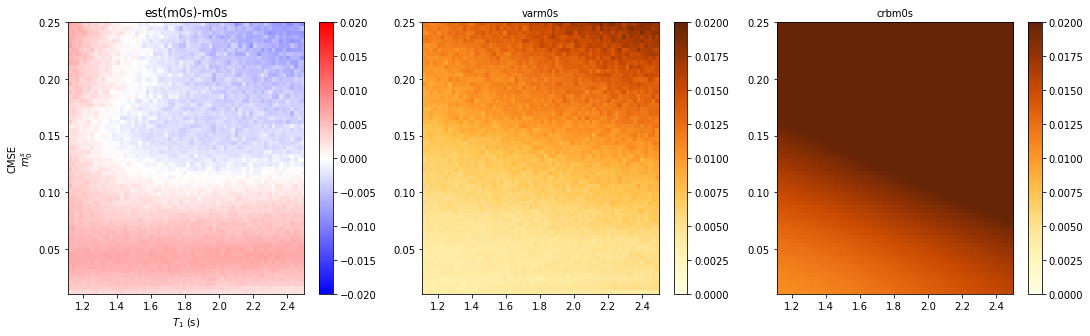

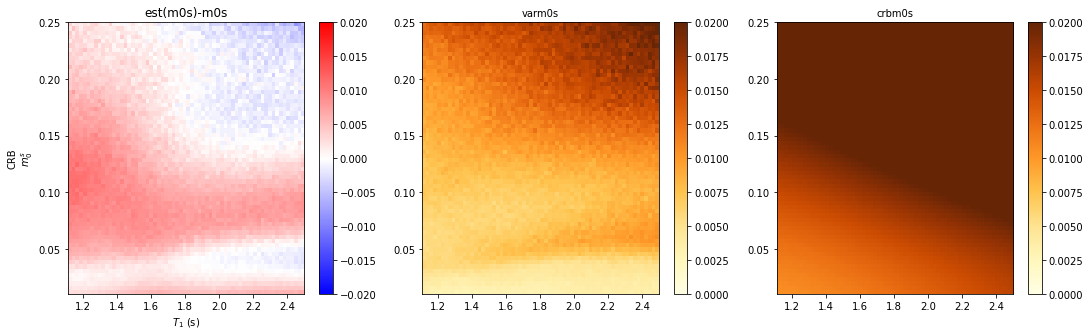

In [24]:
for i in [0,1]:#range(0,3):
    model_name=model_name_list[i]
    data = sio.loadmat(save_root64+model_name+'/'+'m0sT1.mat')
    plot_testgrid_m0s(data,model_title_list[i])

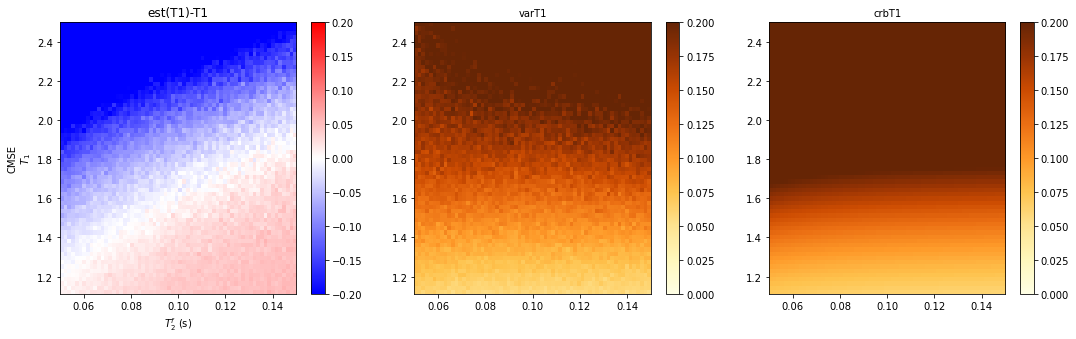

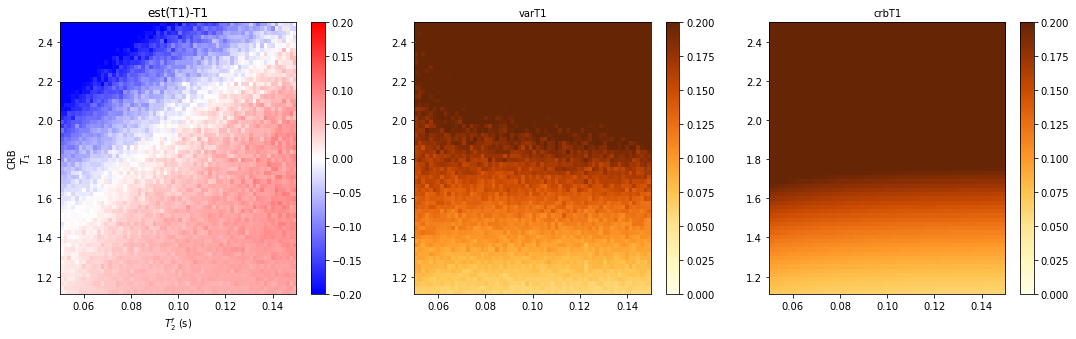

In [25]:
for i in [0,1]:#range(0,3):
    model_name=model_name_list[i]
    data = sio.loadmat(save_root64+model_name+'/'+'T1T2f.mat')
    plot_testgrid_T1(data,model_title_list[i])

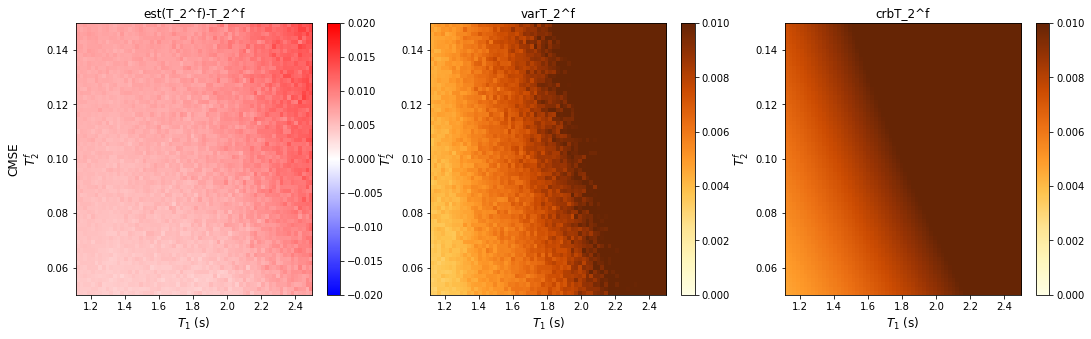

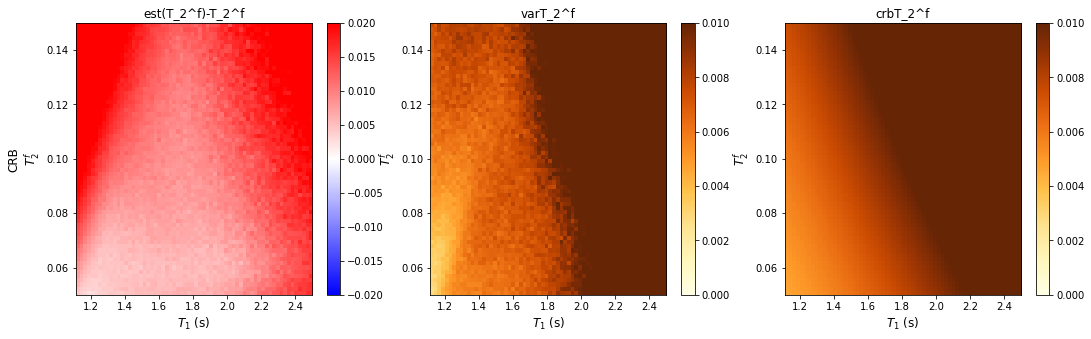

In [27]:
for i in [0,1]:#range(0,3):
    model_name=model_name_list[i]
    data = sio.loadmat(save_root64+model_name+'/'+'T1T2f.mat')
    plot_testgrid_T2(data,model_title_list[i])


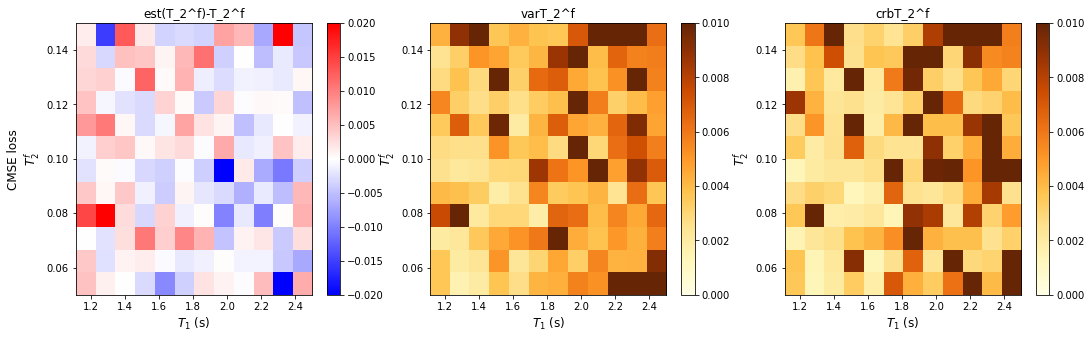

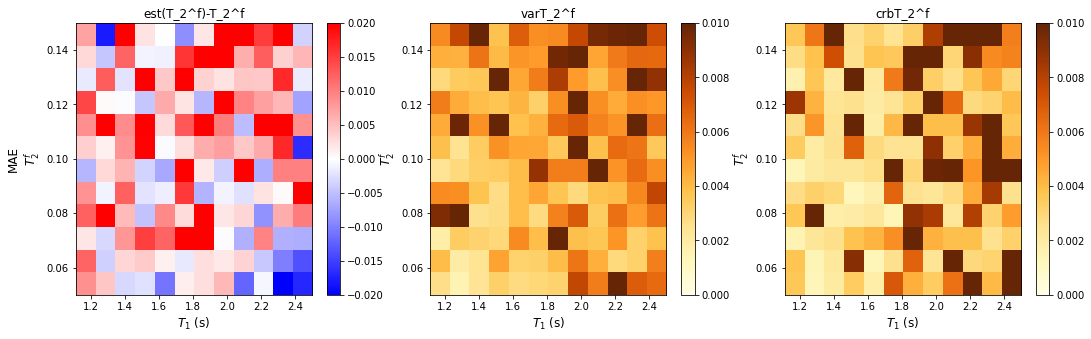

In [66]:
# title = ['CMSE loss','MSE']
for i in [0,2]:#range(0,3):
    model_name=model_name_list[i]
    data = sio.loadmat(save_root12+model_name+'/'+'T1T2f.mat')
    plot_testgrid_T2(data,title[i])

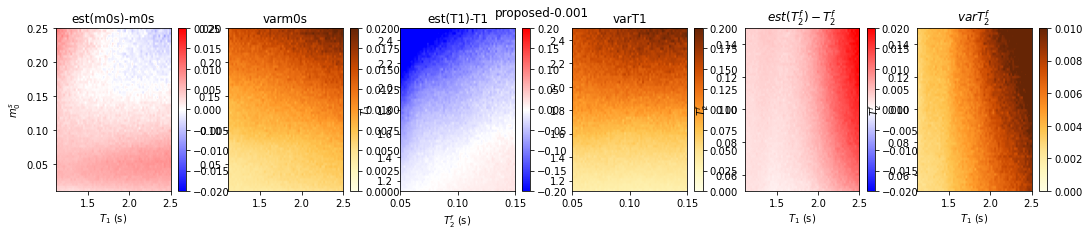

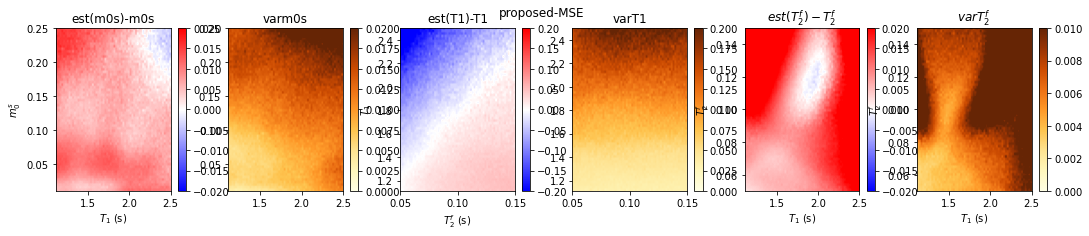

In [132]:
title = ['CMSE loss','MSE']
for i in range(0,2):
    model_name=model_name_list[i]
    data_m0sT1 = sio.loadmat(save_root64+model_name+'/'+'m0sT1.mat')
    data_T1T2f = sio.loadmat(save_root64+model_name+'/'+'T1T2f.mat')
    data = {'m0sT1':data_m0sT1,'T1T2f':data_T1T2f}
    plot_testgrid_compact(data,title)

In [9]:
def plot_testgrid_compact(data_dict):
    row = 1
    col = 6

    bais_cmap='bwr'
    crb_cmap='YlOrBr'
    plt.rcParams["axes.grid"] = False
##==================T1 m0s================
    #bias m0s
    data = data_dict['m0sT1']
    accuracy=0.02
    ax = plt.figure(figsize=(18,2))
    #ax.suptitle(model_title_list[i])
    n=1

    ax=plt.subplot(row, col, n)
    im=data['biasm0s']
    T1=data['T1']
    m0s=data['m0s']
    c = ax.imshow(im, origin='lower', extent=[np.min(T1), np.max(T1), np.min(m0s), np.max(m0s)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel('$m_0^s$', fontsize=font)
    plt.title('est(m0s)-m0s', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

    #variance
    accuracy=0.02
    ax=plt.subplot(row, col, n)
    im=data['varm0s']
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(m0s), np.max(m0s)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    plt.title('varm0s', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

#     #crb
#     ax=plt.subplot(row, col, n)
#     im=data['crbm0s']
#     c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(m0s), np.max(m0s)], cmap=crb_cmap, vmin=0,
#                   vmax=accuracy, aspect="auto")
#     plt.title('crbm0s', fontsize=10)
#     plt.colorbar(c)
#     n=n+1


    ###bias T1
    data = data_dict['T1T2f']
    ax=plt.subplot(row, col, n)
    accuracy=0.2
    im=data['biasT1']
    T1=data['T1']
    T2f=data['T2f']
    c = ax.imshow(im, origin='lower', extent=[np.min(T2f), np.max(T2f), np.min(T1), np.max(T1)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_2^f$ (s)', fontsize=font)
    ax.set_ylabel('$T_1$', fontsize=font)
    plt.title('est(T1)-T1', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

    #variance T1
    accuracy=0.2
    ax=plt.subplot(row, col, n)
    im=data['varT1']
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T2f), np.max(T2f), np.min(T1), np.max(T1)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    plt.title('varT1', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

#     #crb T1
#     ax=plt.subplot(row, col, n)
#     im=data['crbT1']
#     c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T2f), np.max(T2f), np.min(T1), np.max(T1)], cmap=crb_cmap, vmin=0,
#                   vmax=accuracy, aspect="auto")
#     plt.title('crbT1', fontsize=10)
#     plt.colorbar(c)
#     n=n+1

    # T2f
    im=data['biasT2f']
    T1=data['T1']
    T2f=data['T2f']
    ax=plt.subplot(row, col, n)
    accuracy=0.02
    c = ax.imshow(im, origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=bais_cmap, vmin=-accuracy,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel('$T_2^f$', fontsize=font)
    plt.title('$est(T_2^f)-T_2^f$', fontsize=font_large)
    plt.colorbar(c)
    n=n+1

    #variance
    accuracy=0.01
    im=data['varT2f']
    ax=plt.subplot(row, col, n)
    c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=crb_cmap, vmin=0,
                  vmax=accuracy, aspect="auto")
    ax.set_xlabel('$T_1$ (s)', fontsize=font)
    ax.set_ylabel('$T_2^f$', fontsize=font)
    plt.title('$varT_2^f$', fontsize=font_large)
    plt.colorbar(c)
    n=n+1
#     #crb
#     im=data['crbT2f']
#     ax=plt.subplot(row, col, n)
#     c = ax.imshow(np.sqrt(im), origin='lower', extent=[np.min(T1), np.max(T1), np.min(T2f), np.max(T2f)], cmap=crb_cmap, vmin=0,
#                   vmax=accuracy, aspect="auto")
#     ax.set_xlabel('$T_1$ (s)', fontsize=font)
#     ax.set_ylabel('$T_2^f$', fontsize=font)
#     plt.title('crbT_2^f', fontsize=10)
#     plt.colorbar(c)
#     n=n+1
#     sav='/gpfs/data/asslaenderlab/share/zhangx19/code-MRF-april20/bias_variance_plot/draft_figure/'
#     plt.savefig(+'heatmap.png', bbox_inches='tight')

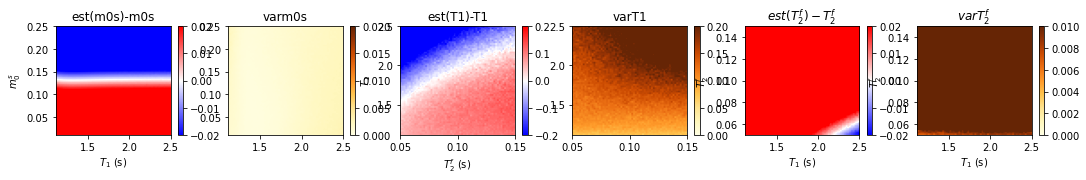

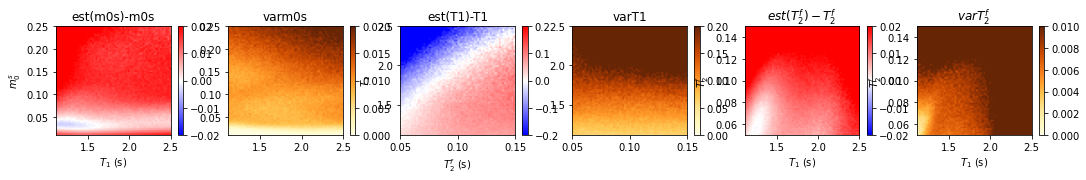

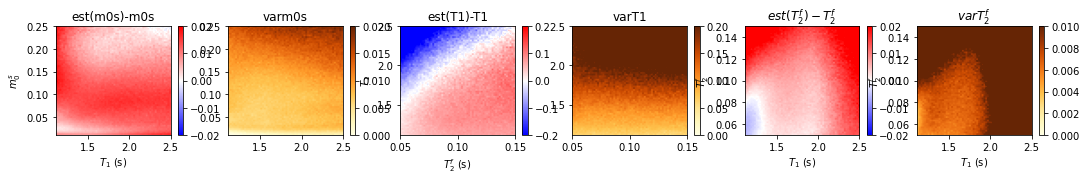

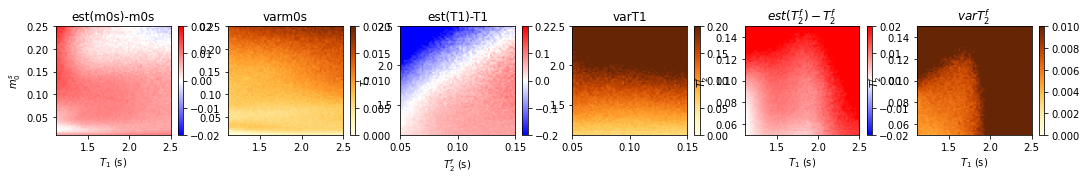

In [10]:
model = importlib.import_module('MRF.models.full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection')
model_name_base='d0428_v3_MSE_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file'
#model_name_base='d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file'
model_name_list = ['CMSE loss','MSE','MAE']
for i in [0,50,100,150]:
    model_name=model_name_base+str(i)
    data_m0sT1 = sio.loadmat(save_root64+model_name+'/'+'m0sT1.mat')
    data_T1T2f = sio.loadmat(save_root64+model_name+'/'+'T1T2f.mat')
    data = {'m0sT1':data_m0sT1,'T1T2f':data_T1T2f}
    plot_testgrid_compact(data)

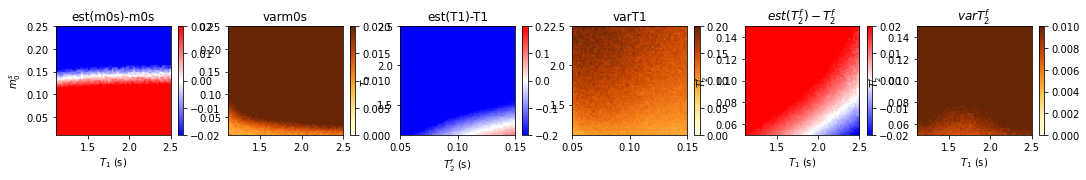

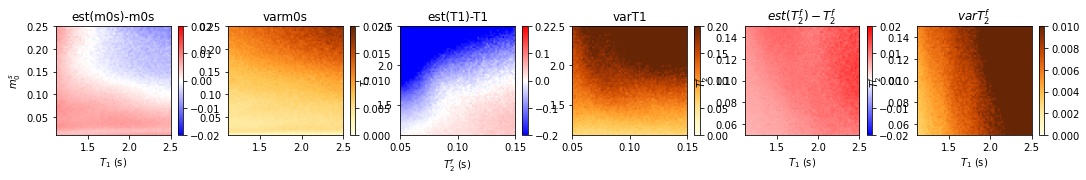

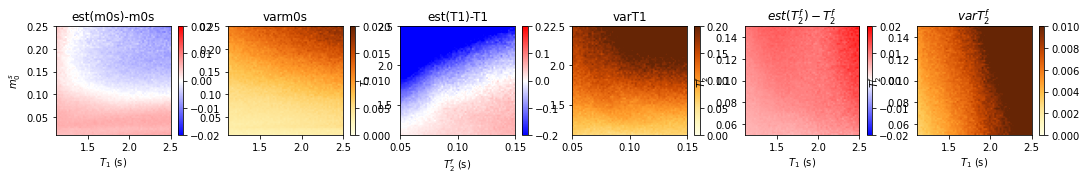

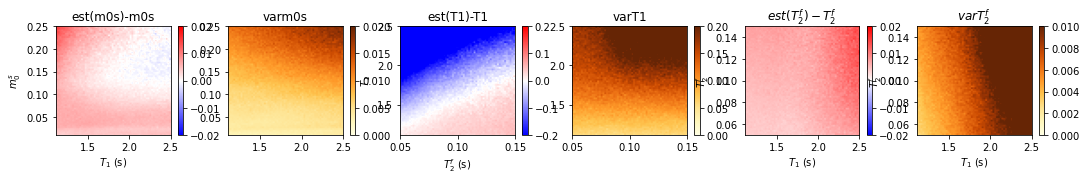

In [11]:
model_name_base='d0428_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01_noise0.01_1100file'
for i in [0,50,100,150]:
    model_name=model_name_base+str(i)
    data_m0sT1 = sio.loadmat(save_root64+model_name+'/'+'m0sT1.mat')
    data_T1T2f = sio.loadmat(save_root64+model_name+'/'+'T1T2f.mat')
    data = {'m0sT1':data_m0sT1,'T1T2f':data_T1T2f}
    plot_testgrid_compact(data)

In [ ]:
model_name_list=[
    #full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection.py
    #proposed
    'd0324_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001',
    'd0324_MSE_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3',
    'd0121_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3',
    'd0324_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.01',
    'd0121_MSE_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3',
    #default B0 B1
    'd0216_v3_sweep_0_B0_0_B1_1_complex_nob1_blochsim_R13_p3',

    #different  D
    #model full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection.py
    'd0320_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R20_p3',
    'd0320_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R15_p3',
    'd0320_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R12_p3',
    'd0320_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R10_p3',
    'd0320_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R8_p3',
    'd0320_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R6_p3',
    
    #geometry_net_noprojection.py, R=13   
    #4layer geometry
    'd0321_geometry_MSE_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3',
    'd0321_geometry_MSECRB_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3',
    
    #geometry_net_noprojection_normalization.py 
    'd0321_geometry_normalize_MSE_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3',
    'd0321_geometry_normalize_MSECRB_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3',
    'd0324_v3_nonsweep_varyB0B1_complex_nob1_blochsim_R13_p3_lr_0.001_without']

R_list=[13,13,13,13,20,15,12,10,8,6,13,13,13,13]

model_list=['full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection',
           'full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection',
           'full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection',
           'full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection',
            #different D
           'full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection',
           'full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection',
           'full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection',
           'full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection',
           'full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection',
           'full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection',
           #geometry
           'geometry_net_noprojection',
           'geometry_net_noprojection',
           #geometry normalize
           'geometry_net_noprojection_normalization',
           'geometry_net_noprojection_normalization']

model_title_list=[#model full_joint_deep3_blochsimv3p2_complexproj_0817_noprojection.py
    #proposed
    'proposed-0.001',            #0
    'proposed-MSE',   #1
    'proposed-0.05',       #2
    'proposed-0.01',       #3
    'proposed-mse',        #2
    #default B0 B1
    'proposed-defaultB0B1',#3
    #different D
    'proposed-20D',        #4
    'proposed-15D',        #5
    'proposed-12D',        #6
    'proposed-10D',        #7
    'proposed-8D',         #8
    'proposed-6D',         #9
    #4layer geometry
    'Geometry-mse',        #10
    'Geometry-crb',        #11
    #4layer geometry normalization
    'Geometry-normalize-mse', #12
    'Geometry-normalize-crb'] #13]
print('done')